[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/swati-rajwal/BreastCancer_tweets_project/blob/main/F_Different_sentiment_analyzers.ipynb)

In [ ]:
# !pip install bertopic
# pip install pandas matplotlib seaborn
# pip install stanza

In [20]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic
import gensim
nltk.download('punkt')
nltk.download('stopwords')
import string
import seaborn as sns
import matplotlib.pyplot as plt
import stanza
from transformers import pipeline
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/srajwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/srajwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/srajwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/srajwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/srajwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/srajwal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# NLTK Sentiment analyzer

Sentment scores file saved!!!


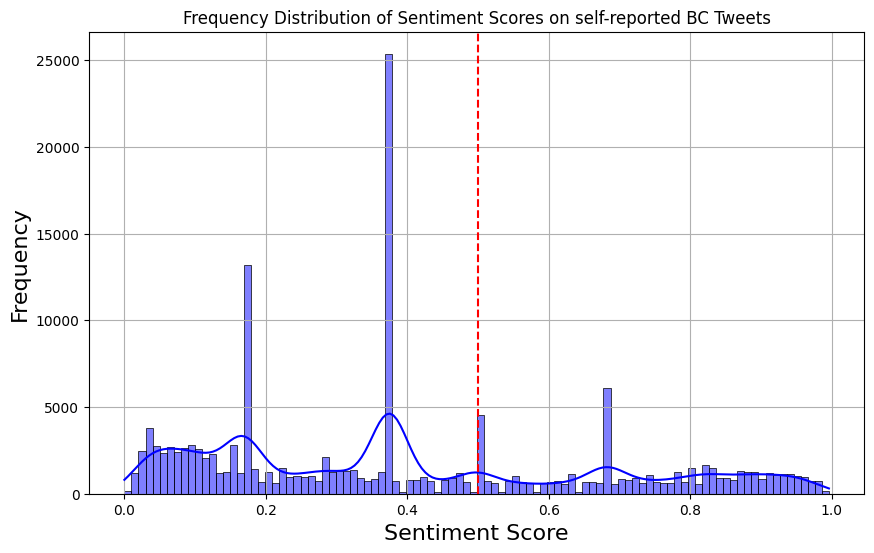

In [4]:
#### Reading roberta predicted data (Because this model performed the best) #######
df = pd.read_csv('/local/scratch/shared-directories/ssanet/swati_folder/bionlp/Breast Cancer Data/Predictions/BC_full_data_roberta_predictions.csv')
df = df[df['roberta_predictions']==1].copy()
print(f"unique class labels: {df['roberta_predictions'].unique()}")

sia = SentimentIntensityAnalyzer()
df['sentiment_on_original'] = df['original_text'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)   ## Original text
df['sentiment_on_preprocessed'] = df['text'].apply(lambda x: (sia.polarity_scores(x)['compound'] + 1) / 2)    # Preprocessed text
df.to_csv('/local/scratch/shared-directories/ssanet/swati_folder/bionlp/Breast Cancer Data/Predictions/roberta_prediction_1_only_with_sentiment.csv',index=False)
print("Sentment scores file saved!!!")

plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_on_preprocessed'], bins=100,  color='blue',kde=True)
plt.title('Frequency Distribution of Sentiment Scores on self-reported BC Tweets')
plt.xlabel('Sentiment Score',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.axvline(x=0.5, color='red', linestyle='--')
plt.grid(True)
plt.show()

df_nltk shape after >=0.7 sentiment score: (28695, 7)
Starting similary function now
df_nltk.shape: (12024, 8)


2024-04-02 14:33:31,383 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/376 [00:00<?, ?it/s]

2024-04-02 14:33:35,423 - BERTopic - Embedding - Completed ✓
2024-04-02 14:33:35,424 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-02 14:33:41,175 - BERTopic - Dimensionality - Completed ✓
2024-04-02 14:33:41,176 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-02 14:33:41,643 - BERTopic - Cluster - Completed ✓
2024-04-02 14:33:41,647 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-02 14:33:42,089 - BERTopic - Representation - Completed ✓


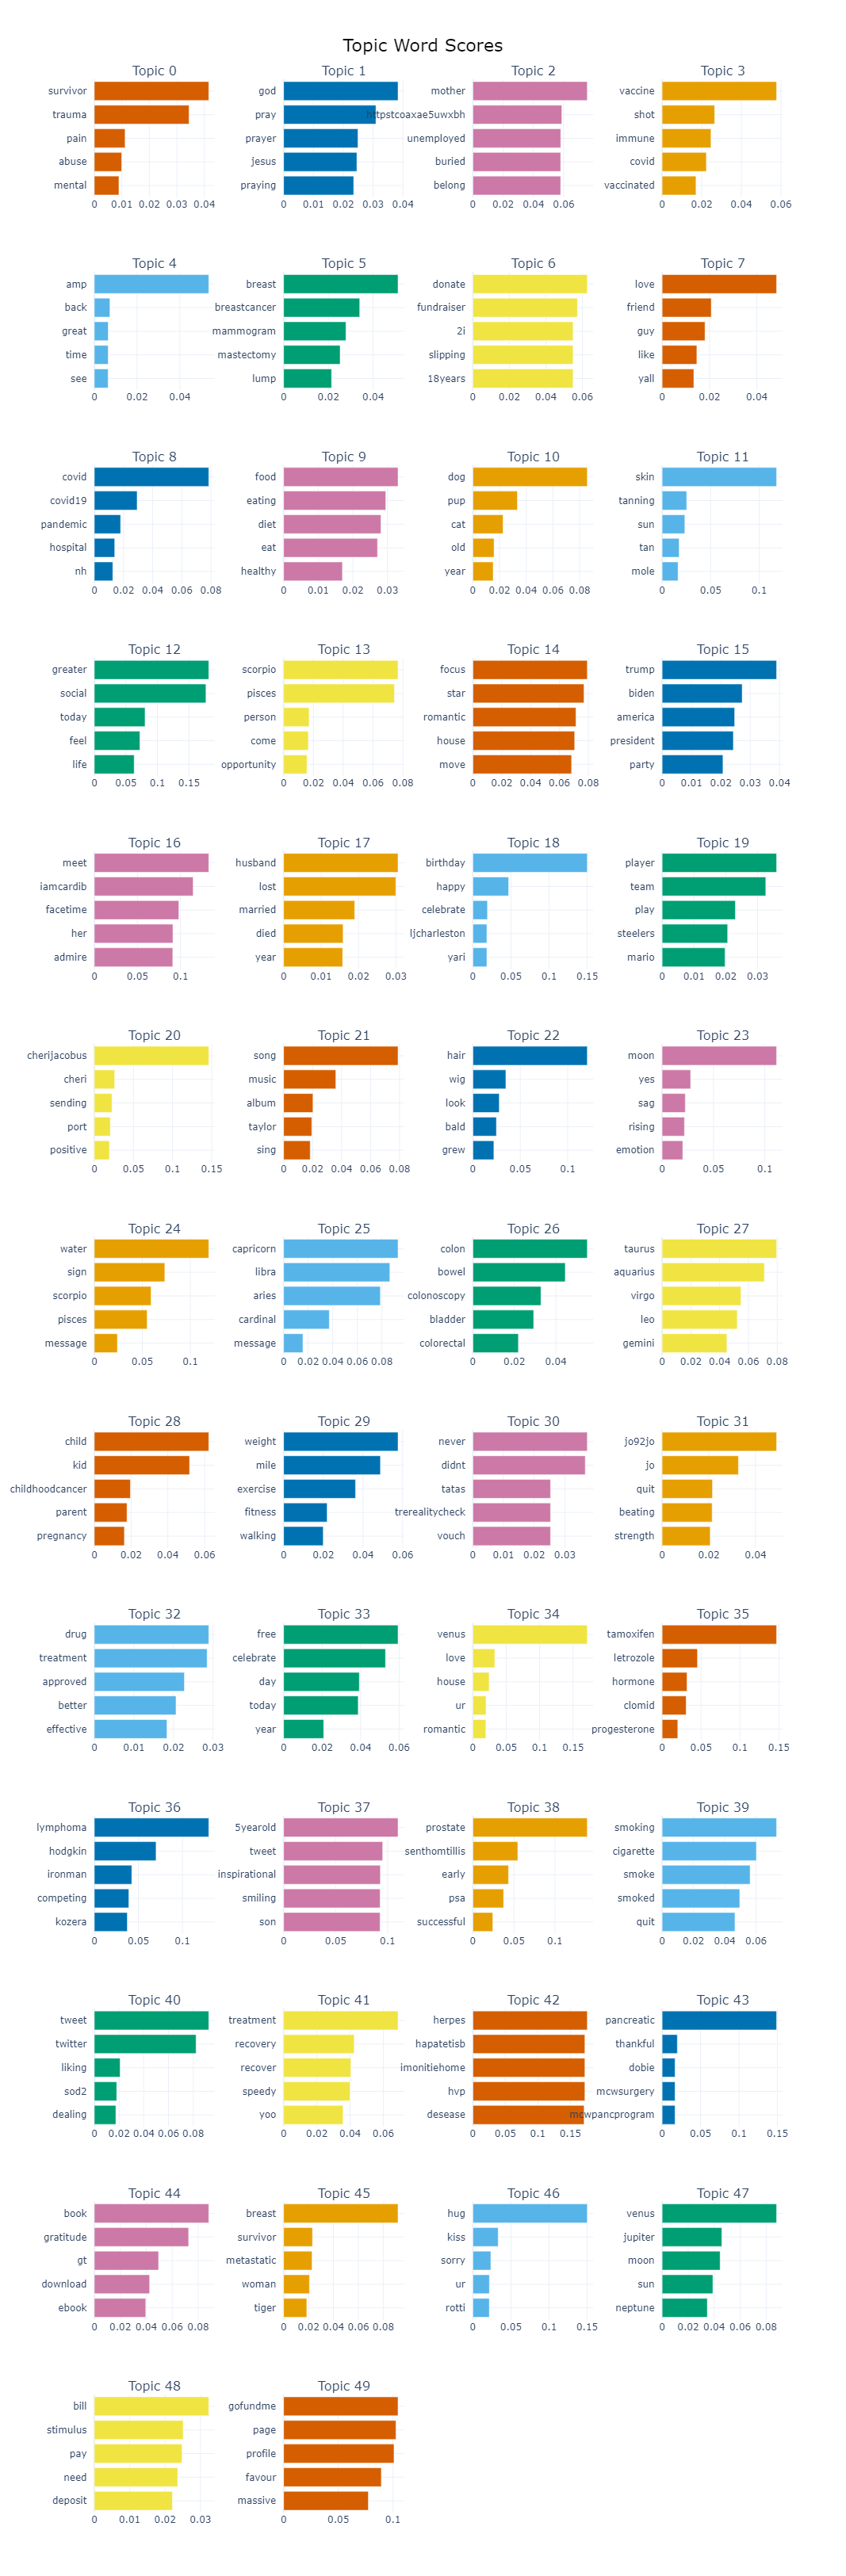

In [32]:
## POSITIVE TOPICS
# word_vectors = KeyedVectors.load_word2vec_format('/labs/sarkerlab/srajwal/BC project/GoogleNews-vectors-negative300.bin', binary=True)
df_nltk = df[df['sentiment_on_preprocessed'] >= 0.7].copy()  # Filter Tweets with positive sentiments
df_nltk = df_nltk.reset_index(drop=True)
print(f"df_nltk shape after >=0.7 sentiment score: {df_nltk.shape}")

# Filter posts that contain treatment side-effect / negative keywords
treatment_bc_negative_keywords = ["treatment","medication","medicine","med","tablets","side effect","reaction","drug","tamoxifen","chemo","mental","emotion",
                     "lump","pain","sleep","docetaxel","oncologist","doc" "stop"]  # Keywords based on literature review of Pub_med papers (reference in main article)
print("Starting similary function now")
# Function to find similar words in a text
# def find_similar_words(text, word_vectors, uncertainty_words, threshold=0.5):
def find_similar_words(index, text, word_vectors, uncertainty_words, threshold=0.5):
    similar_words = []
    unc_words = []
    # print(f"Processing row index: {index}",flush=True)  # Print the current row index
    for word in text.lower().split():
        if word in word_vectors:
            word_embedding = word_vectors[word]
            for unc_word in uncertainty_words:
                if unc_word in word_vectors:
                    unc_embedding = word_vectors[unc_word]
                    similarity = cosine_similarity([word_embedding], [unc_embedding])[0][0]
                    if similarity > threshold:
                        similar_words.append(word)
                        similar_words.append(unc_word)
                        break
    return similar_words

df_nltk['similar_uncertainty_words'] = [find_similar_words(idx, row['text'], word_vectors, treatment_bc_negative_keywords) for idx, row in df_nltk.iterrows()]
df_nltk = df_nltk[df_nltk['similar_uncertainty_words'].str.len() > 0].copy()
print(f"df_nltk.shape: {df_nltk.shape}",flush=True)
self_reported_texts = df_nltk['text'].to_list() # 'text' is preprocessed and 'original_text' is not
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(self_reported_texts)
topic_model.visualize_barchart(top_n_topics=50) # Visualize Topic Modelling Figure

# StandordNLP stanzapackage

In [8]:
df=pd.read_csv('/labs/sarkerlab/srajwal/BC project/roberta_prediction_1_only_with_sentiment.csv')

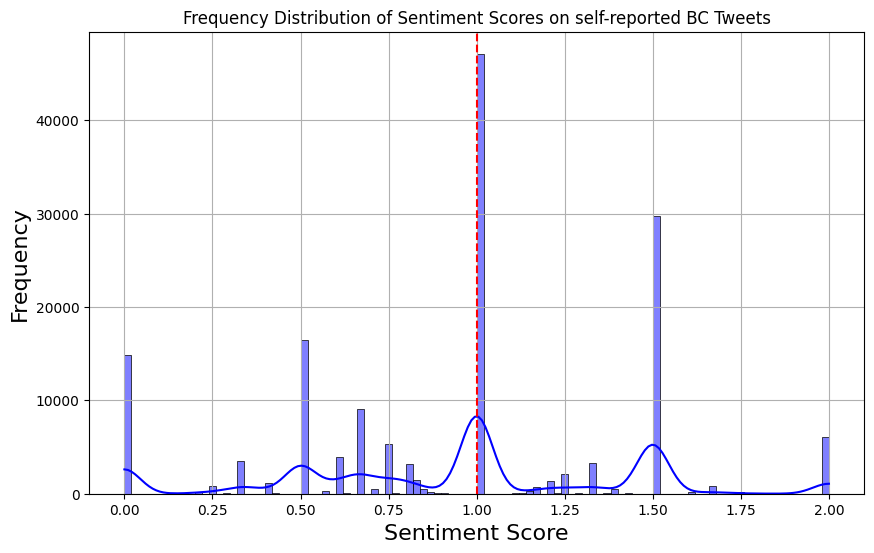

In [12]:
##### Calculate sentiment score #########
stanza.download('en')
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
def stanza_sentiment(text):
    doc = nlp_stanza(text)
    sentiments = [sentence.sentiment for sentence in doc.sentences] # sentiment scores are for sentences, aggregate across the text.
    return sum(sentiments) / len(sentiments)  # Simple average
df['stanza_sentiment'] = df['original_text'].apply(stanza_sentiment)
print("value count of sentiment:")
df['stanza_sentiment'].value_counts(dropna=False)

###### Plot ##########
plt.figure(figsize=(10, 6))
sns.histplot(df['stanza_sentiment'], bins=100,  color='blue',kde=True)
plt.title('Frequency Distribution of Sentiment Scores on self-reported BC Tweets')
plt.xlabel('Sentiment Score',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.axvline(x=1.0, color='red', linestyle='--')
plt.grid(True)
plt.show()

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format('/labs/sarkerlab/srajwal/BC project/GoogleNews-vectors-negative300.bin', binary=True)
df_stanford = df[df['stanza_sentiment'] <= 1.0].copy()  # Filter Tweets with negative sentiments
df_stanford = df_stanford.reset_index(drop=True)
print(f"df shape after <=1.0 sentiment score: {df_stanford.shape}")

# Filter posts that contain treatment side-effect / negative keywords
treatment_bc_negative_keywords = ["treatment","medication","medicine","med","tablets","side effect","reaction","drug","tamoxifen","chemo","mental","emotion",
                     "lump","pain","sleep","docetaxel","oncologist","doc" "stop"]  # Keywords based on literature review of Pub_med papers (reference in main article)
print("Starting similary function now")
# Function to find similar words in a text
# def find_similar_words(text, word_vectors, uncertainty_words, threshold=0.5):
def find_similar_words(index, text, word_vectors, uncertainty_words, threshold=0.5):
    similar_words = []
    unc_words = []
    # print(f"Processing row index: {index}",flush=True)  # Print the current row index
    for word in text.lower().split():
        if word in word_vectors:
            word_embedding = word_vectors[word]
            for unc_word in uncertainty_words:
                if unc_word in word_vectors:
                    unc_embedding = word_vectors[unc_word]
                    similarity = cosine_similarity([word_embedding], [unc_embedding])[0][0]
                    if similarity > threshold:
                        similar_words.append(word)
                        similar_words.append(unc_word)
                        break
    return similar_words

df_stanford['similar_uncertainty_words'] = [find_similar_words(idx, row['text'], word_vectors, treatment_bc_negative_keywords) for idx, row in df_stanford.iterrows()]
df_stanford.to_csv('/labs/sarkerlab/srajwal/BC project/roberta_prediction_1_only_with_sentiment_treatment_similar_words_stanford.csv', index=False)
df_stanford = df_stanford[df_stanford['similar_uncertainty_words'].str.len() > 0].copy()
print(f"df_stanford.shape: {df_stanford.shape}",flush=True)

# Extracting tweets of self reported BC with negative sentiments
self_reported_texts = df_stanford['text'].to_list() # 'text' is preprocessed and 'original_text' is not
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(self_reported_texts)
topic_model.visualize_barchart(top_n_topics=50) # Visualize Topic Modelling Figure

df shape after <=1.0 sentiment score: (109025, 6)
Starting similary function now
df_stanford.shape: (78258, 7)


2024-04-02 01:19:19,957 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2446 [00:00<?, ?it/s]

2024-04-02 01:19:36,503 - BERTopic - Embedding - Completed ✓
2024-04-02 01:19:36,504 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-02 01:20:31,241 - BERTopic - Dimensionality - Completed ✓
2024-04-02 01:20:31,244 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

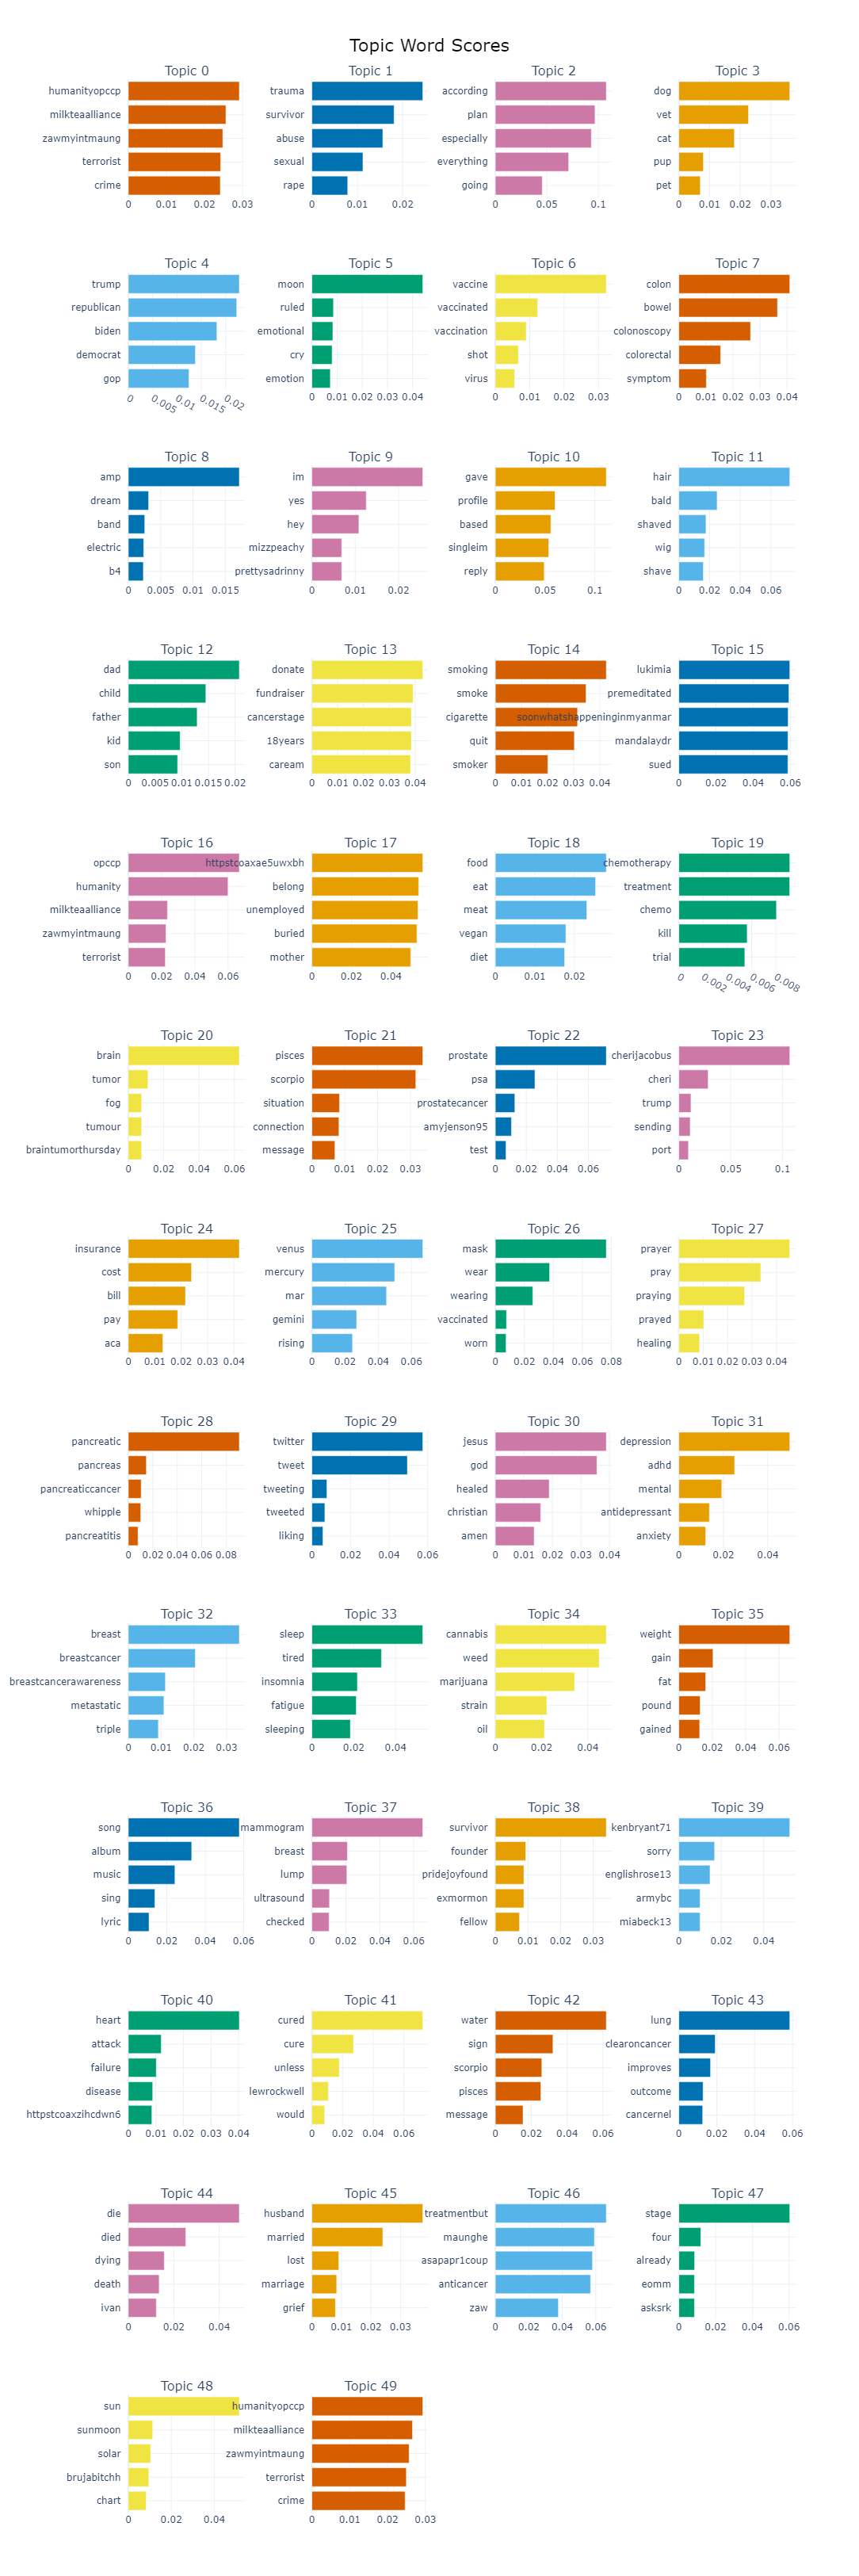

In [16]:
topic_model.visualize_barchart(top_n_topics=50) # Visualize Topic Modelling Figure

df shape after >=1.5 sentiment score: (36964, 7)
Starting similary function now
df_stanford.shape: (30466, 8)


2024-04-02 13:45:56,641 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/953 [00:00<?, ?it/s]

2024-04-02 13:46:02,684 - BERTopic - Embedding - Completed ✓
2024-04-02 13:46:02,685 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-02 13:46:17,301 - BERTopic - Dimensionality - Completed ✓
2024-04-02 13:46:17,302 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

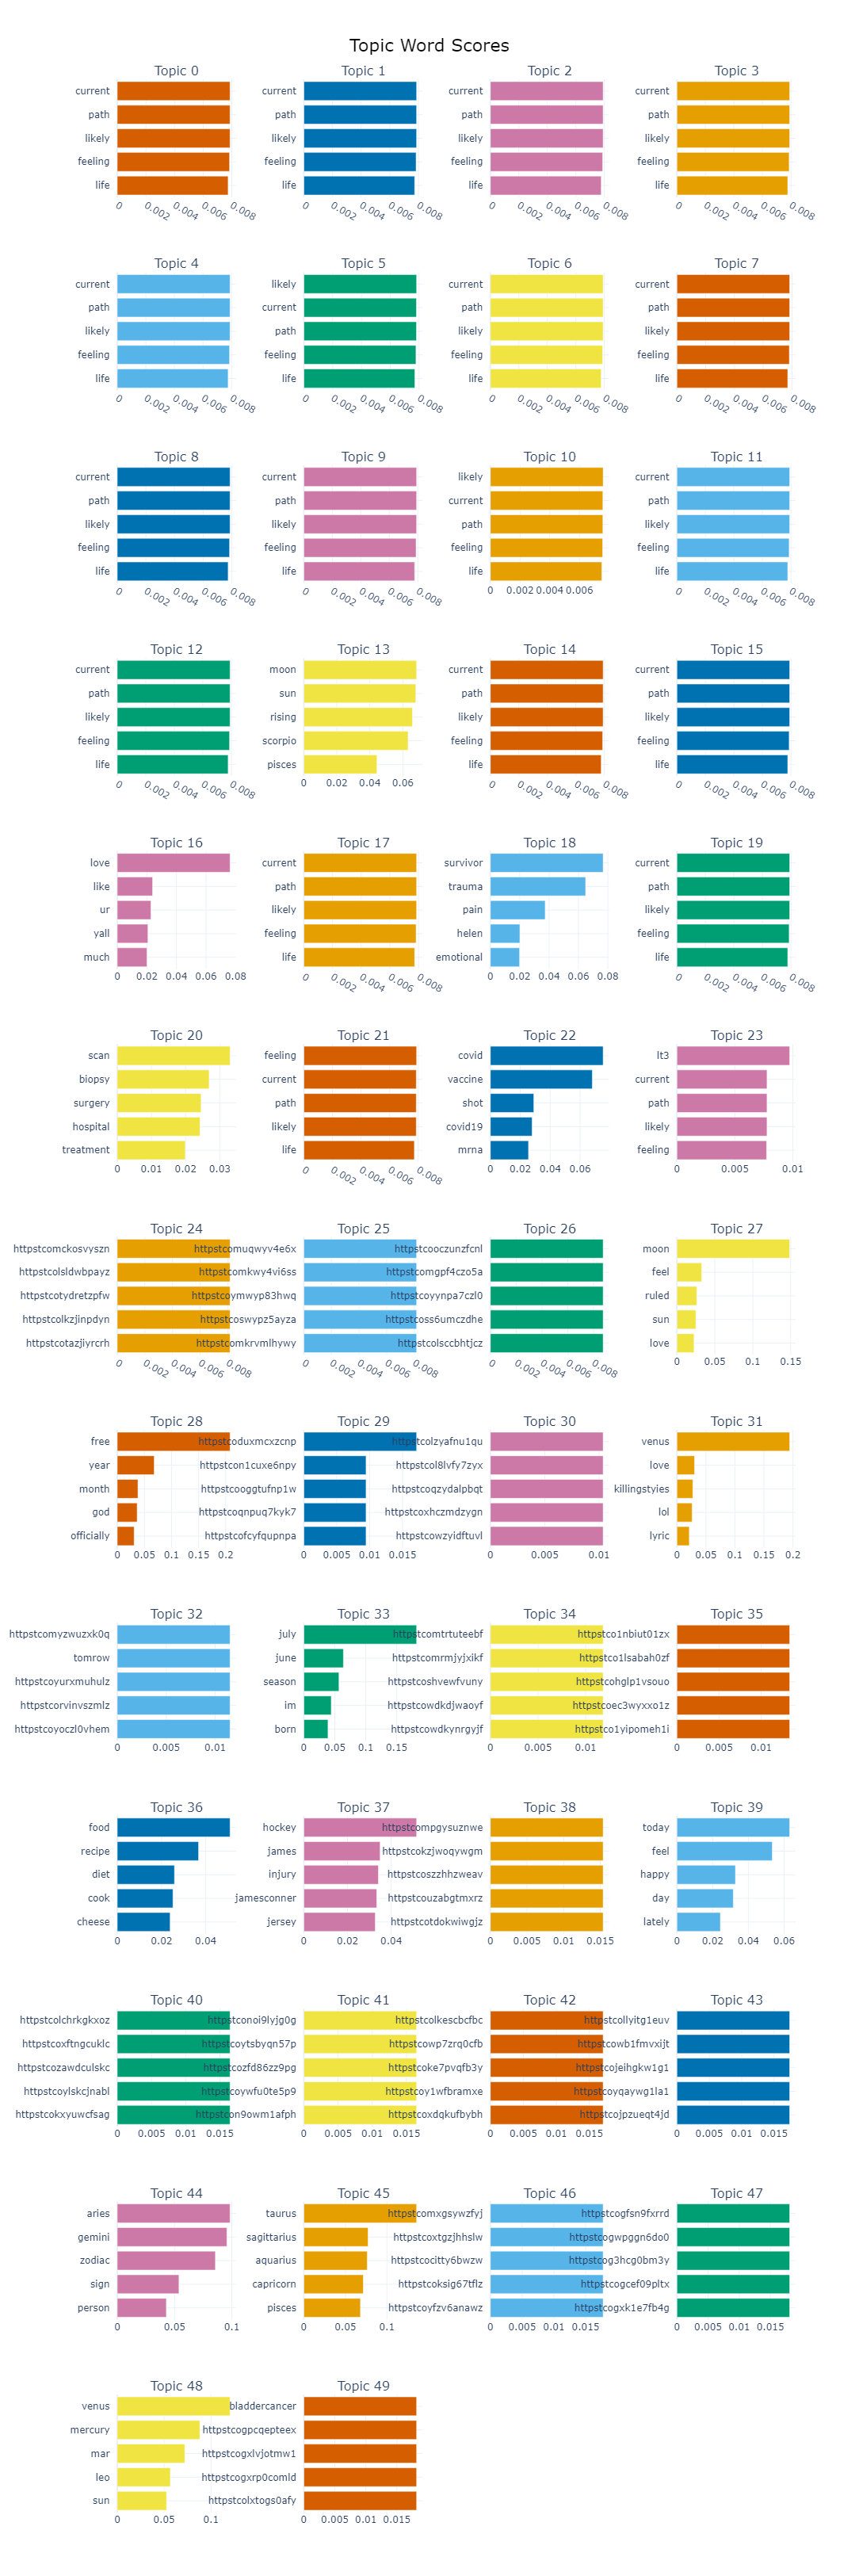

In [26]:
## POSITIVE TOPICS
word_vectors = KeyedVectors.load_word2vec_format('/labs/sarkerlab/srajwal/BC project/GoogleNews-vectors-negative300.bin', binary=True)
df_stanford = df[df['stanza_sentiment'] >= 1.5].copy()  # Filter Tweets with positive sentiments
df_stanford = df_stanford.reset_index(drop=True)
print(f"df shape after >=1.5 sentiment score: {df_stanford.shape}")

# Filter posts that contain treatment side-effect / negative keywords
treatment_bc_negative_keywords = ["treatment","medication","medicine","med","tablets","side effect","reaction","drug","tamoxifen","chemo","mental","emotion",
                     "lump","pain","sleep","docetaxel","oncologist","doc" "stop"]  # Keywords based on literature review of Pub_med papers (reference in main article)
print("Starting similary function now")
# Function to find similar words in a text
# def find_similar_words(text, word_vectors, uncertainty_words, threshold=0.5):
def find_similar_words(index, text, word_vectors, uncertainty_words, threshold=0.5):
    similar_words = []
    unc_words = []
    # print(f"Processing row index: {index}",flush=True)  # Print the current row index
    for word in text.lower().split():
        if word in word_vectors:
            word_embedding = word_vectors[word]
            for unc_word in uncertainty_words:
                if unc_word in word_vectors:
                    unc_embedding = word_vectors[unc_word]
                    similarity = cosine_similarity([word_embedding], [unc_embedding])[0][0]
                    if similarity > threshold:
                        similar_words.append(word)
                        similar_words.append(unc_word)
                        break
    return similar_words

df_stanford['similar_uncertainty_words'] = [find_similar_words(idx, row['text'], word_vectors, treatment_bc_negative_keywords) for idx, row in df_stanford.iterrows()]
df_stanford = df_stanford[df_stanford['similar_uncertainty_words'].str.len() > 0].copy()
print(f"df_stanford.shape: {df_stanford.shape}",flush=True)
self_reported_texts = df_stanford['text'].to_list() # 'text' is preprocessed and 'original_text' is not
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(self_reported_texts)
topic_model.visualize_barchart(top_n_topics=50) # Visualize Topic Modelling Figure

# Hugging Face Sentiment Analyzer

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


value count of sentiment:


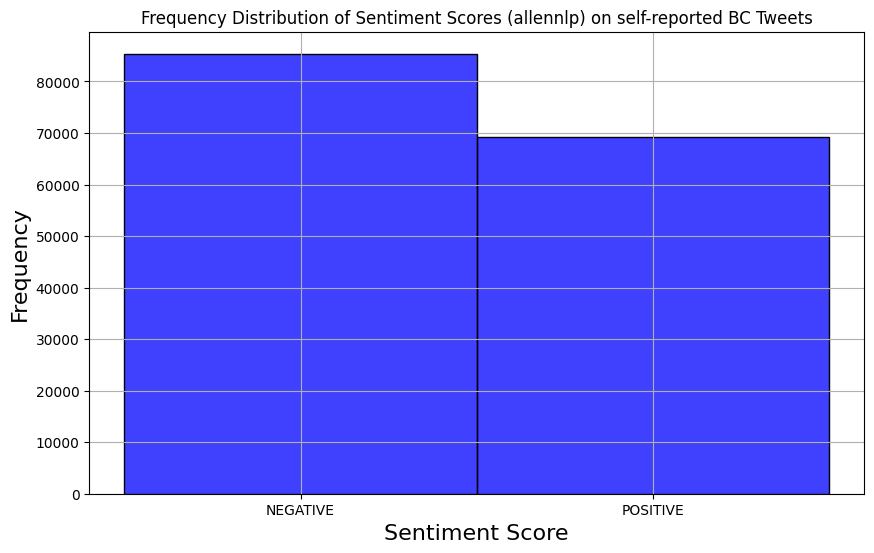

In [17]:
sentiment_pipeline = pipeline('sentiment-analysis')
def huggingface_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label']  # Returns POSITIVE or NEGATIVE with a score

df['huggingface_sentiment'] = df['original_text'].apply(lambda x: huggingface_sentiment(x))

print("value count of sentiment:")
df['huggingface_sentiment'].value_counts(dropna=False)

######### Plot ##########
plt.figure(figsize=(10, 6))
sns.histplot(df['huggingface_sentiment'], bins=10,  color='blue')
plt.title('Frequency Distribution of Sentiment Scores (allennlp) on self-reported BC Tweets')
plt.xlabel('Sentiment Score',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.grid(True)
plt.show()

df shape with NEGATIVE sentiment value: (85382, 7)
Starting similary function now
df_hugging.shape: (64505, 8)


2024-04-02 05:16:38,135 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2016 [00:00<?, ?it/s]

2024-04-02 05:16:51,336 - BERTopic - Embedding - Completed ✓
2024-04-02 05:16:51,337 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-02 05:17:25,257 - BERTopic - Dimensionality - Completed ✓
2024-04-02 05:17:25,259 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

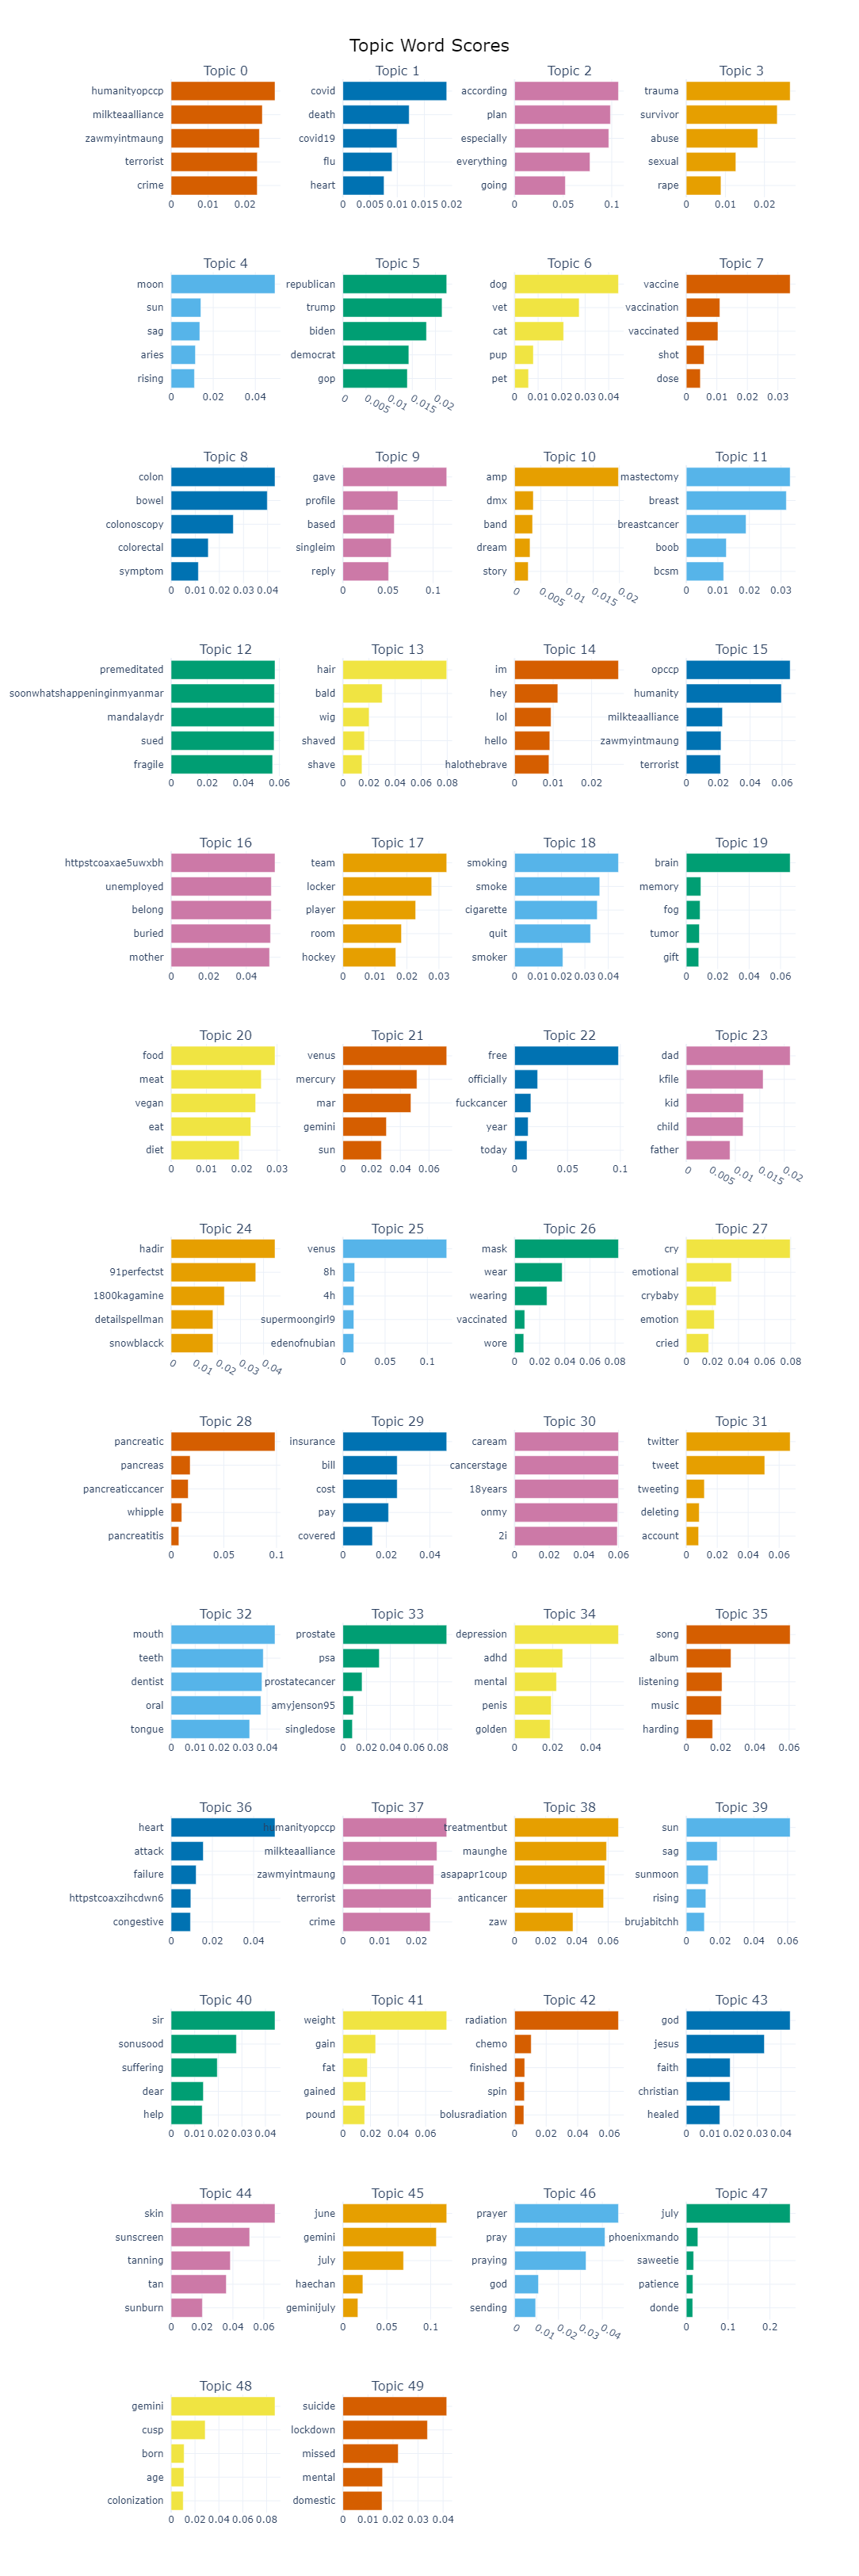

In [18]:
word_vectors = KeyedVectors.load_word2vec_format('/labs/sarkerlab/srajwal/BC project/GoogleNews-vectors-negative300.bin', binary=True)
# Filter Tweets with negative sentiments
df_hugging = df[df['huggingface_sentiment'] == 'NEGATIVE']
df_hugging = df_hugging.reset_index(drop=True)
print(f"df shape with NEGATIVE sentiment value: {df_hugging.shape}")

# Filter posts that contain treatment side-effect / negative keywords
treatment_bc_negative_keywords = ["treatment","medication","medicine","med","tablets","side effect","reaction","drug","tamoxifen","chemo","mental","emotion",
                     "lump","pain","sleep","docetaxel","oncologist","doc" "stop"]  # Keywords based on literature review of Pub_med papers (reference in main article)
print("Starting similary function now")
# Function to find similar words in a text
# def find_similar_words(text, word_vectors, uncertainty_words, threshold=0.5):
def find_similar_words(index, text, word_vectors, uncertainty_words, threshold=0.5):
    similar_words = []
    unc_words = []
    # print(f"Processing row index: {index}",flush=True)  # Print the current row index
    for word in text.lower().split():
        if word in word_vectors:
            word_embedding = word_vectors[word]
            for unc_word in uncertainty_words:
                if unc_word in word_vectors:
                    unc_embedding = word_vectors[unc_word]
                    similarity = cosine_similarity([word_embedding], [unc_embedding])[0][0]
                    if similarity > threshold:
                        similar_words.append(word)
                        similar_words.append(unc_word)
                        break
    return similar_words

df_hugging['similar_uncertainty_words'] = [find_similar_words(idx, row['text'], word_vectors, treatment_bc_negative_keywords) for idx, row in df_hugging.iterrows()]
df_hugging.to_csv('/labs/sarkerlab/srajwal/BC project/roberta_prediction_1_only_with_sentiment_treatment_similar_words_hugging.csv', index=False)
df_hugging = df_hugging[df_hugging['similar_uncertainty_words'].str.len() > 0].copy()
print(f"df_hugging.shape: {df_hugging.shape}",flush=True)
self_reported_texts = df_hugging['text'].to_list()  # Extracting tweets of self reported BC with negative sentiments
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(self_reported_texts)
topic_model.visualize_barchart(top_n_topics=50) # Visualize Topic Modelling Figure

df shape after <=1.0 sentiment score: (69189, 7)
Starting similary function now
df_hugging.shape: (49998, 8)


2024-04-02 06:17:58,107 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2024-04-02 06:18:07,604 - BERTopic - Embedding - Completed ✓
2024-04-02 06:18:07,605 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-02 06:18:29,988 - BERTopic - Dimensionality - Completed ✓
2024-04-02 06:18:29,989 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

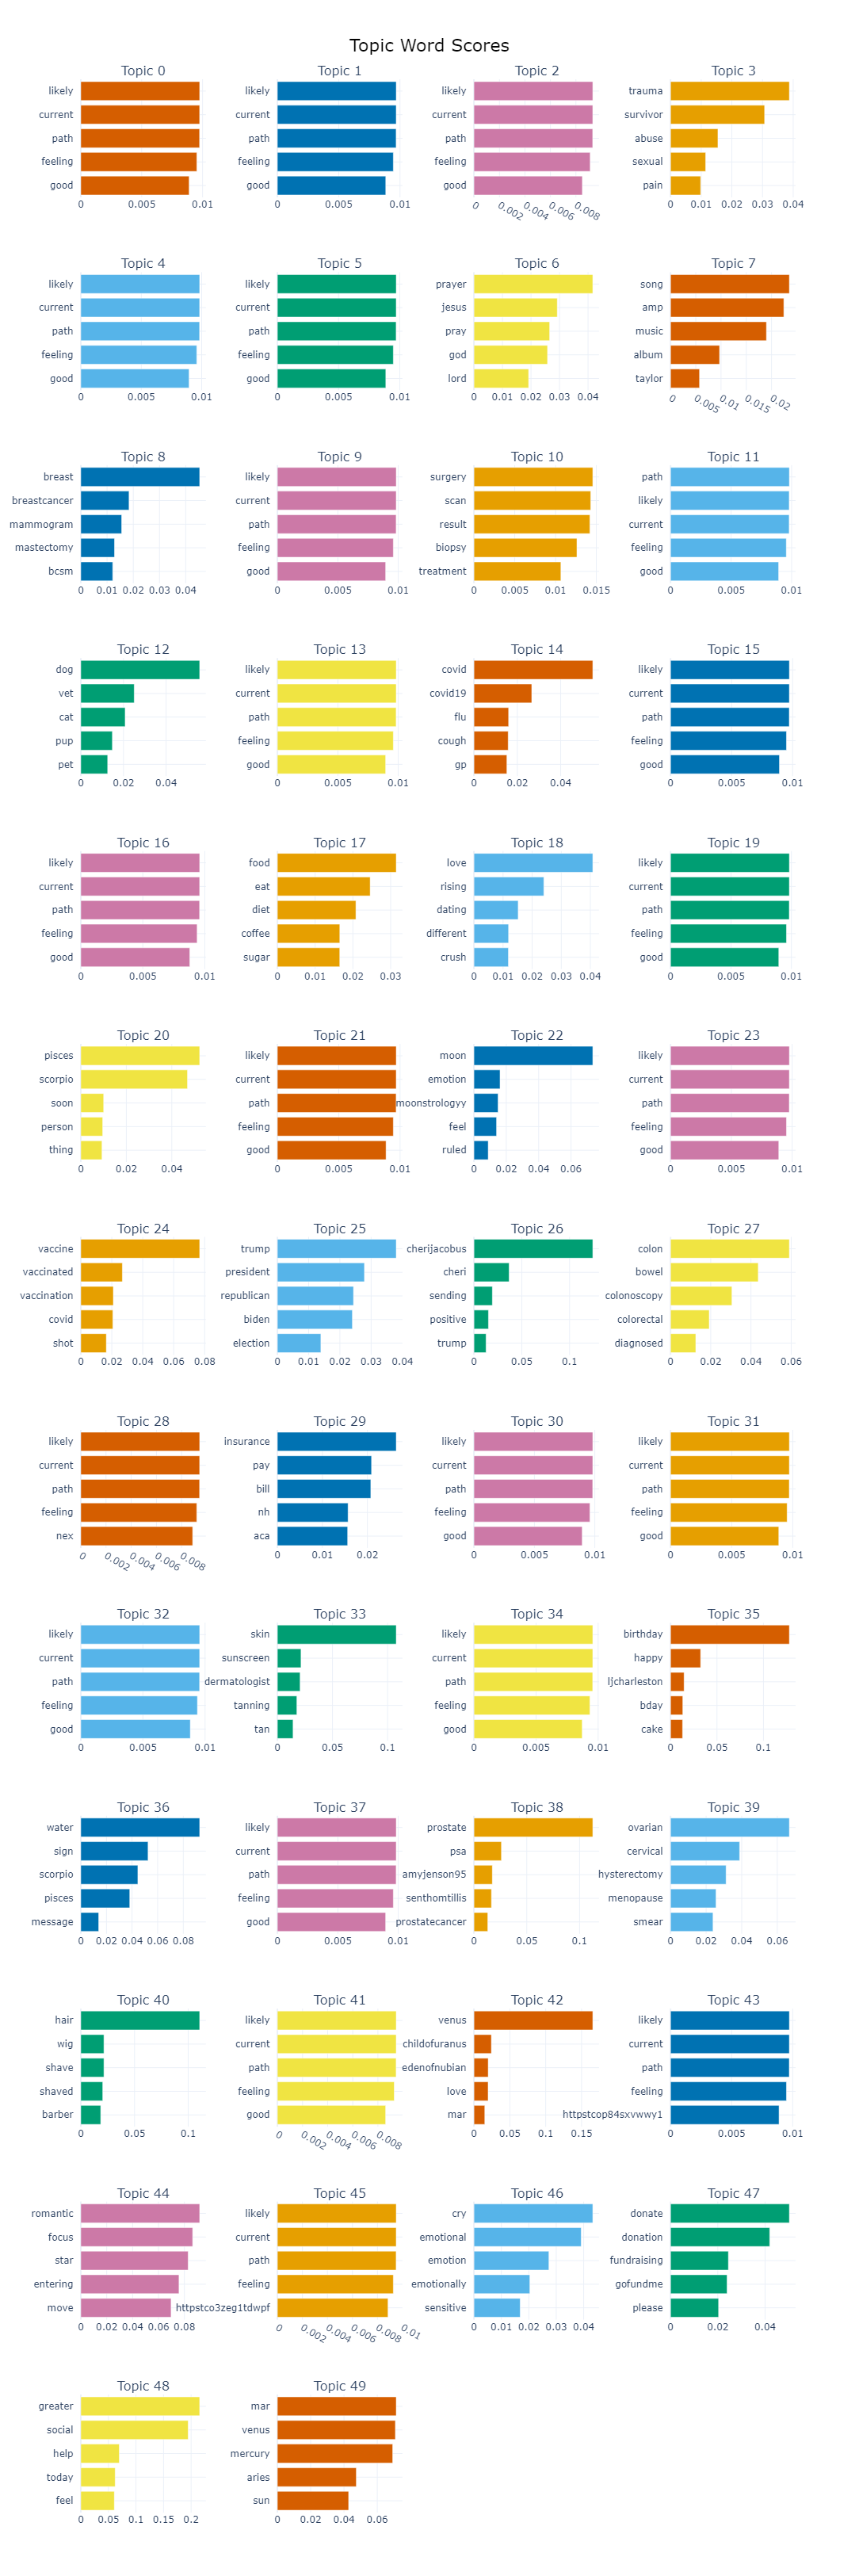

In [19]:
word_vectors = KeyedVectors.load_word2vec_format('/labs/sarkerlab/srajwal/BC project/GoogleNews-vectors-negative300.bin', binary=True)
# Filter Tweets with negative sentiments
df_hugging = df[df['huggingface_sentiment'] == 'POSITIVE']
df_hugging = df_hugging.reset_index(drop=True)
print(f"df shape after positive sentiment score: {df_hugging.shape}")

# Filter posts that contain treatment side-effect / negative keywords
treatment_bc_negative_keywords = ["treatment","medication","medicine","med","tablets","side effect","reaction","drug","tamoxifen","chemo","mental","emotion",
                     "lump","pain","sleep","docetaxel","oncologist","doc" "stop"]  # Keywords based on literature review of Pub_med papers (reference in main article)
print("Starting similary function now")
# Function to find similar words in a text
# def find_similar_words(text, word_vectors, uncertainty_words, threshold=0.5):
def find_similar_words(index, text, word_vectors, uncertainty_words, threshold=0.5):
    similar_words = []
    unc_words = []
    # print(f"Processing row index: {index}",flush=True)  # Print the current row index
    for word in text.lower().split():
        if word in word_vectors:
            word_embedding = word_vectors[word]
            for unc_word in uncertainty_words:
                if unc_word in word_vectors:
                    unc_embedding = word_vectors[unc_word]
                    similarity = cosine_similarity([word_embedding], [unc_embedding])[0][0]
                    if similarity > threshold:
                        similar_words.append(word)
                        similar_words.append(unc_word)
                        break
    return similar_words

df_hugging['similar_uncertainty_words'] = [find_similar_words(idx, row['text'], word_vectors, treatment_bc_negative_keywords) for idx, row in df_hugging.iterrows()]
df_hugging = df_hugging[df_hugging['similar_uncertainty_words'].str.len() > 0].copy()
print(f"df_hugging.shape: {df_hugging.shape}",flush=True)
self_reported_texts = df_hugging['text'].to_list()  # Extracting tweets of self reported BC with negative sentiments
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(self_reported_texts)
topic_model.visualize_barchart(top_n_topics=50) # Visualize Topic Modelling Figure